# Python Assignment 5 Pragmatic Section
Team B

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
import sounddevice as sd
import librosa
import librosa.display
import math
import scipy
import time
from scipy import signal
import os
import pandas as pd
import random
from scipy.io.wavfile import write
import soundfile as sf

In [2]:
# Add classes for file information, instrument filters, and pure data integration
class FileClass:
    def __init__(self, sig, inst):
        self.signal = sig
        self.instrument = inst
        
class InstrumentFilters:
    def __init__(self):
        # fc = random odd number from 1 to 99
        self.firTaps = random.randrange(1, 51, 2)
        # fc = random float from 0 to 0.5
        self.fc = (random.random()/2)
        # chose filter 0 to 6 in pure data
        self.iirFilter = random.randrange(6)
        
class PureDataIIR:
    def __init__(self, iirFilter, instrument):
        # Apply IIR filter through pure data
        self.filtertype = 'filtertype ' + str(iirFilter)
        self.instrument = instrument
    
    def filterFile(self, file, filePath):
        # Define command line variables
        fileName = ('fileName ' + filePath)
        filteredFileName = file.replace(".wav", "_" + self.instrument + "_filtered.wav")
        filteredFilePath = filePath.replace("database/" + file , "filtered/" + filteredFileName)
        fileFiltered = ('newFileName '+ filteredFilePath)
        startFiltering = ('startFiltering 1') 
        
        send = ' -send "; ' + str(self.filtertype) + '; ' + str(fileName) + '; ' + str(fileFiltered) + '; ' + str(startFiltering) + '; "'
        command = pd_executable + ' -open ' + pd_patch + send  + ' -nogui' + ' -batch'
        os.system(command)
        
        return filteredFilePath

In [3]:
# Add graphing functions
def graph_spectrogram(s,titleBeginning):
    D = librosa.stft(s)
    DdB = librosa.amplitude_to_db(abs(D))
    
    plt.figure(figsize=(10, 3))
    librosa.display.specshow(DdB, sr=sr, x_axis='time', y_axis='hz')
    plt.title(titleBeginning + " Spectrogram")
    plt.show()
    
def graph_calculation_vs_librosa(calculated, fromLibrosa, titleBeginning):
    t = np.linspace(0, len(fromLibrosa), len(fromLibrosa))
    plt.figure(figsize=(20, 3))
    plt.xlabel("Audio File")
    plt.ylabel(titleBeginning)
    plt.grid(True)
    if (calculated == []):
        # For spectral bandwidth
        plt.plot(fromLibrosa, 'r--')
        plt.title(titleBeginning + " Averages From Librosa")
    else:
        # For spectral centroid and RMS
        plt.plot(t, calculated, 'b', t, fromLibrosa, 'r--')
        plt.legend(('calculated', 'librosa'), loc='best')
        plt.title(titleBeginning + " Averages Calculated Vs. Librosa")
    
    plt.show()

In [17]:
#converting the files to 16-bit, because the filtered files generated in PureData were generated in 64-bit. 
def convertFiles(directory):
    for file in os.listdir(directory):
        if(file.endswith('.wav')):
            nameSolo = file.rsplit('.', 1)[0]
            data, samplerate = sf.read(directory +'/' + file)                
            sf.write('./files/filtered/' + nameSolo + '.wav', data, samplerate, subtype='PCM_16')            

In [5]:
# sets pd executable path
pd_executable = '/Applications/Pd-0.51-4.app/Contents/Resources/bin/pd' #for OSX Pd 0.51-4
pd_patch = './Assignment5BiquadFilter.pd'
#pd_executable = 'C:\Program Files\pd\bin\pd.exe' #for Windows
#pd_executable = '/usr/local/bin/pd ' #for Linux

In [6]:
# Create list of file classes, which store file name, instrument, rms, spectral centroid, and spectral bandwidth
fileClasses = {}

# Store file names and instruments in arrays we are assuming that row 0 is files and row 1 is instruments)
dataFrame = pd.read_csv('./files/database/meta.csv')
columnNames = dataFrame.columns.values
fileNames = dataFrame[columnNames[0]]
instrument = dataFrame[columnNames[1]]
instrumentTypes = pd.unique(instrument)

# Iterate through all files, load them using librosa, and save them to the fileClasses dictionary
for i in range(0, fileNames.size):
    y, sr = librosa.load('./files/database/' + fileNames[i], sr=44100, mono=True)
    newClass = FileClass(y, instrument[i])
    fileClasses[fileNames[i]] = newClass

# 1. Compute Average for RMS, Spectral Centroid, and Spectral Bandwidth

In [7]:
# These lists will hold the average values of our calculated values and librosa values for RMS and spectral centroid 
# so we can compare them after we go through each file
calculatedRmsArray = []
librosaRmsArray = []
calculatedSpectralCentroidArray = []
librosaSpectralCentroidArray = []
# We will also keep track of the average spectral bandwidth for each file for display later
librosaSpectralBandwidthArray = []

# This dictionary will keep track of all average values for the different instruments. We will use this in the 
# 3D graph later
instrumentAverages = {}
for instrument in instrumentTypes:
    instrumentAverages[instrument] = {
        'rms': [],
        'sc': [],
        'sb': []
    }
    
for file in fileClasses:
    if (file.endswith('.' + 'wav')):
        # Load file and perform FFT ('S' is the absolute value of the full FFT array, 'magnitude' is only the
        # positive half of the FFT array)
        y = fileClasses[file].signal
        S = np.abs(scipy.fft.fft(y))
        magnitude = np.abs(S[0:math.floor(len(S)/2)+1])
        
        # Calculate RMS manually
        rmsAverage = math.sqrt(np.sum(pow(S, 2)) / pow(S.size, 2))
        calculatedRmsArray.append(rmsAverage)
        
        # Calculate RMS with Librosa
        rmsLibrosaAverage = librosa.feature.rms(S=magnitude, frame_length=(magnitude.size * 2 - 1))[0]
        librosaRmsArray.append(rmsLibrosaAverage)
        
        # Calculate spectral centroid manually
        freqs = np.linspace(0, sr/2, magnitude.size)
        scAverage = (np.sum(magnitude * freqs)) / np.sum(magnitude)
        calculatedSpectralCentroidArray.append(scAverage)
        
        # Calculate spectral centroid with librosa
        scLibrosaAverage = librosa.feature.spectral_centroid(y=y, sr=44100, n_fft=y.size, hop_length=(y.size + 1))[0][0]
        librosaSpectralCentroidArray.append(scLibrosaAverage)
        
        # Calculate spectral bandwidth with librosa
        sbLibrosaAverage = librosa.feature.spectral_bandwidth(y=y, sr=44100, n_fft=y.size, hop_length=(y.size + 1))[0][0]
        librosaSpectralBandwidthArray.append(sbLibrosaAverage)
        
        # Add averages to each file class
        instrument = fileClasses[file].instrument
        instrumentAverages[instrument]['rms'].append(rmsAverage)
        instrumentAverages[instrument]['sc'].append(scAverage)
        instrumentAverages[instrument]['sb'].append(sbLibrosaAverage)

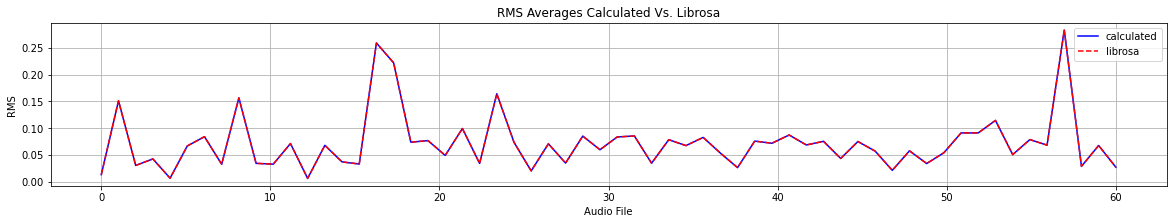

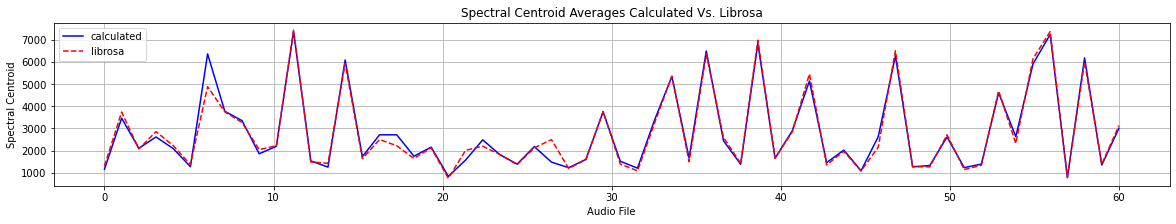

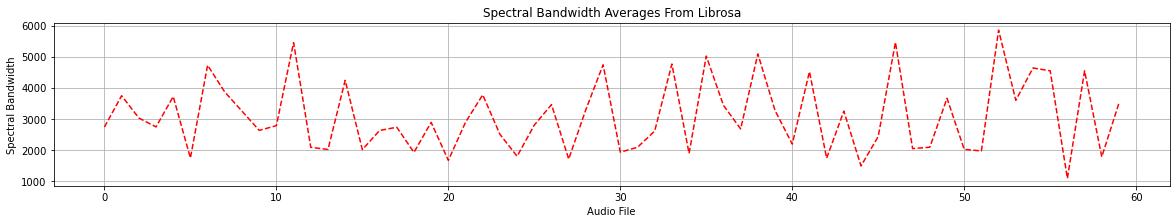

In [8]:
# Graph our calculated values vs. librosa's values
graph_calculation_vs_librosa(calculatedRmsArray, librosaRmsArray, "RMS")
graph_calculation_vs_librosa(calculatedSpectralCentroidArray, librosaSpectralCentroidArray, "Spectral Centroid")
graph_calculation_vs_librosa([], librosaSpectralBandwidthArray, "Spectral Bandwidth")

# 2. Display 3D Scatter Plot

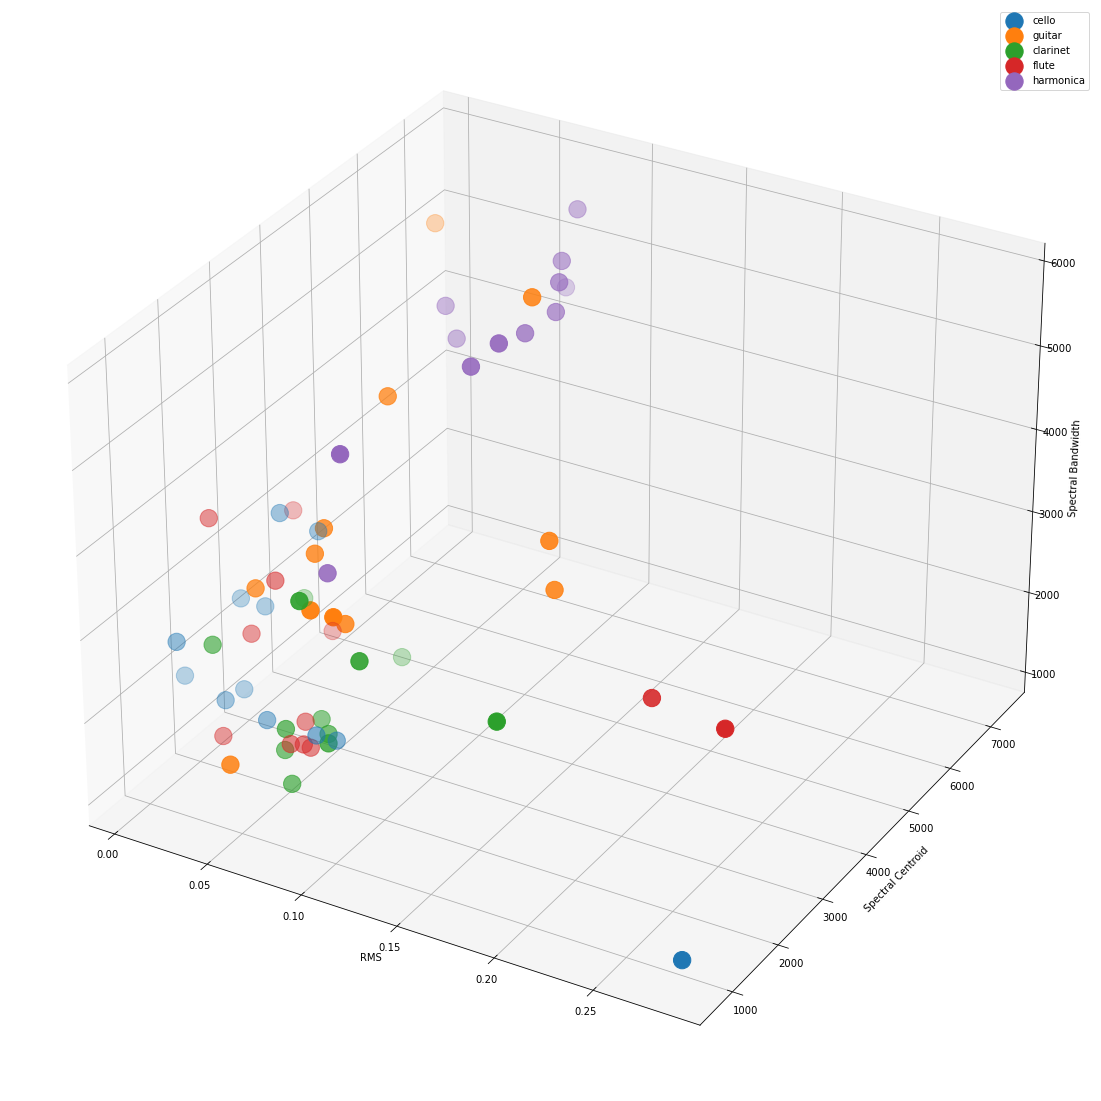

In [9]:
plt.figure(figsize=(20, 20))
ax = plt.axes(projection='3d')
for instrument in instrumentAverages:
    rms = instrumentAverages[instrument]['rms']
    sc = instrumentAverages[instrument]['sc']
    sb = instrumentAverages[instrument]['sb']
    ax.scatter3D(rms, sc, sb, s=300)

plt.legend(instrumentTypes, loc='best')
ax.set_xlabel('RMS')
ax.set_ylabel('Spectral Centroid')
ax.set_zlabel('Spectral Bandwidth');


# 3. Apply Filters to Each File

In [10]:
# Create folder for filtered files if there isn't one already
filteredPath = "./files/filtered/"
if( os.path.isdir(filteredPath) == False ):
    os.mkdir(filteredPath)

instrumentFilters = {}
PureDataIIRFilters = {}

# Create filters and PureDataIIR classesfor each instrument
for instrument in instrumentTypes:
    instrumentFilters[instrument] = InstrumentFilters()
    
    filters = instrumentFilters[instrument]
    iirFilter = filters.iirFilter
    PureDataIIRFilters[instrument] = PureDataIIR(iirFilter, instrument)

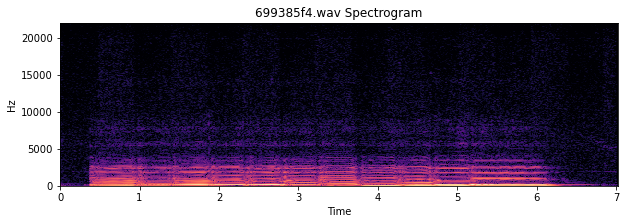

./files/filtered/699385f4_cello_filtered.wav


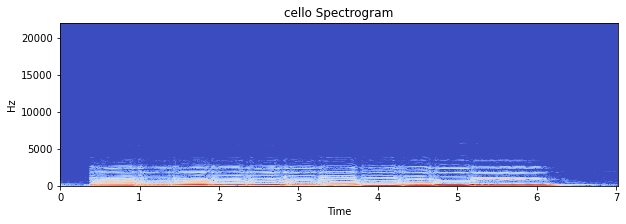

./files/filtered/699385f4_guitar_filtered.wav


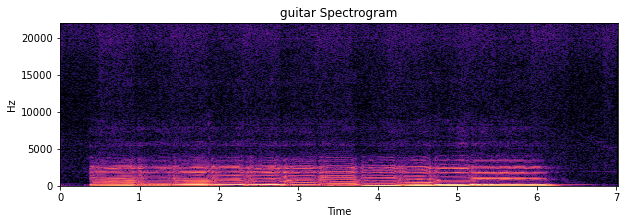

./files/filtered/699385f4_clarinet_filtered.wav


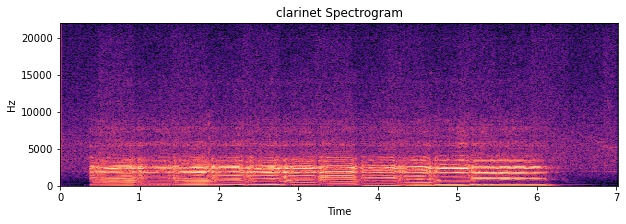

./files/filtered/699385f4_flute_filtered.wav


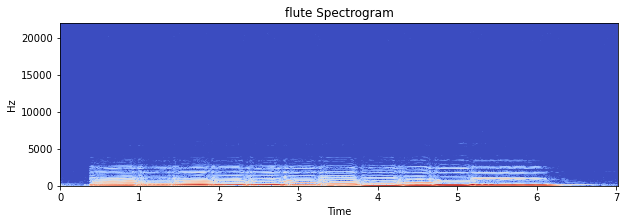

./files/filtered/699385f4_harmonica_filtered.wav


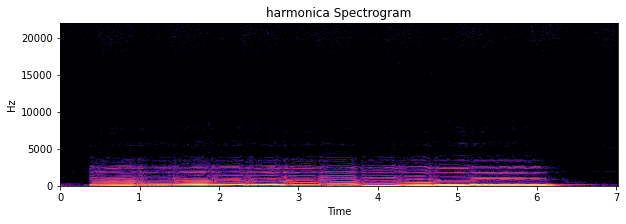

In [11]:
# Apply both filters to the first file to demonstrate their effect on the spectrogram
file = next(iter(fileClasses))
filePath = "./files/database/" + file
originalFile, sr = librosa.load(filePath, sr=44100, mono=True)

graph_spectrogram(originalFile, file)

for instrument in instrumentFilters:
    # Load IIR filtered file, apply FIR filter, and overwrite filtered file
    filteredFilePath = PureDataIIRFilters[instrument].filterFile(file, filePath)
    filters = instrumentFilters[instrument]
    
    filtered, sr = librosa.load(filteredFilePath, sr=44100, mono=True)
    numtaps = filters.firTaps
    fc = filters.fc
    h = signal.firwin(numtaps, fc, pass_zero='highpass')
    
    filtered = signal.lfilter(h, 1, filtered)
    write(filteredFilePath, sr, filtered)
    
    graph_spectrogram(filtered, instrument)

In [12]:
# Create folder for filtered files if there isn't one already
filteredPath = "./files/filtered/"
if( os.path.isdir(filteredPath) == False ):
    os.mkdir(filteredPath)

for file in fileClasses:
    instrument = fileClasses[file].instrument
    filters = instrumentFilters[instrument]

    #Apply IIR filters to all Audio Files
    filePath = "./files/database/" + file
    filteredFilePath = PureDataIIRFilters[instrument].filterFile(file, filePath)

    # Load IIR filtered file, apply FIR filter in frequency domain, and overwrite filtered file
    y, sr = librosa.load(filteredFilePath, sr=44100, mono=True)
    numtaps = filters.firTaps
    fc = filters.fc
    h = signal.firwin(numtaps, fc, pass_zero='highpass')
    h_padded = np.pad(h,[0,y.size-h.size])
    X = scipy.fft.fft(y)
    H = scipy.fft.fft(h_padded)
    Y = X*H
    # signal with FIR filter applied
    y = np.real(scipy.fft.ifft(Y))
    write(filteredFilePath, sr, y)

In [18]:
#converting the files to 16-bit. 
convertFiles('./files/filtered')